# **In this file I analyze the errors in the spectral domain at various time steps as well as for white matter and grey matter regions for all 6 patients**

In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)


In [2]:
Undersampling = "Regular" #Regular or Possoin
Sampling_Mask = "Complementary_Masks" #One_Mask or Single_Combination or Complementary_Masks
AF = 34644020944

**Load and transform data**

In [3]:
Rank = 8

mask = np.load('../data/masks.npy')
mask_6D = mask[:,:,:, np.newaxis, np.newaxis, :]

### Load data and tracuate
Ground_Truth = np.load('../data/Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy')  #combined_trancuated_k_space_low_rank_15
Undersampled_Data = np.load("../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy')

# apply mask
Ground_Truth = Ground_Truth#*mask_6D
Undersampled_Data = Undersampled_Data#*mask_6D

# apply low rank
Ground_Truth_L8 = np.zeros_like(Ground_Truth)
Undersampled_Data_L8 = np.zeros_like(Undersampled_Data)
# Ground_Truth_L8 = low_rank(Ground_Truth, Rank)

#apply low rank
for i in range(0,6):
    Ground_Truth_L8[...,i] = low_rank(Ground_Truth[...,i], Rank)
    Undersampled_Data_L8[...,i] = low_rank(Undersampled_Data[...,i], Rank)
    
### apply general maks
Ground_Truth_L8 = Ground_Truth_L8*mask_6D
Undersampled_Data_L8 = Undersampled_Data_L8*mask_6D

### Transform to spectral domain 
Ground_Truth_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_L8, axis=-3),axes=-3)
Undersampled_Data_Spectral_L8 = np.fft.fftshift(np.fft.fft(Undersampled_Data_L8, axis=-3),axes=-3)

**Compute errors as function of spectral index and T**

In [4]:
### Compute squared absolute difference wrt to ground truth
error = np.abs(Ground_Truth_Spectral_L8 - Undersampled_Data_Spectral_L8)**2

### Average over spatial dimensions to get MSE for spatial dimenisons as a function 
mse_per_spatial_volume = np.mean(error, axis=(0, 1, 2))


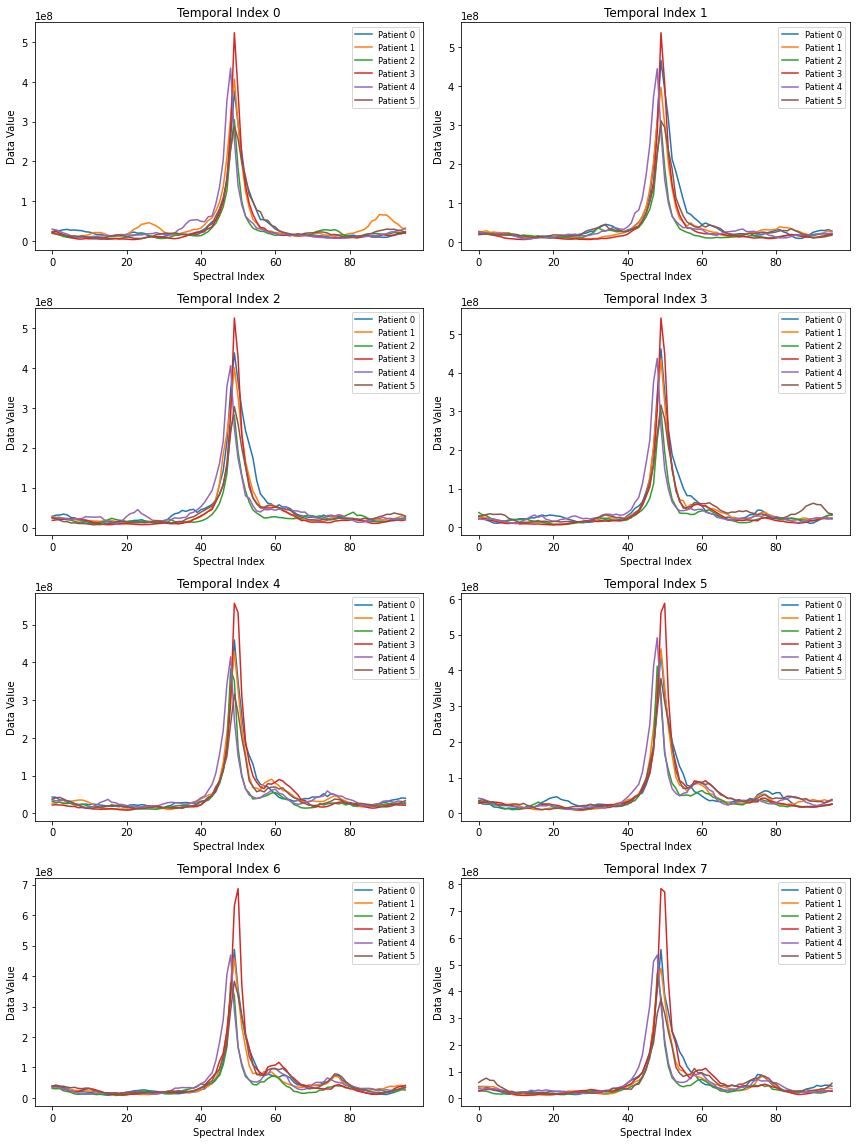

In [5]:
# Create 8 subplots in a grid of 4 rows x 2 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Loop over each temporal index (0 to 7)
for temporal_idx in range(mse_per_spatial_volume.shape[1]):
    # Determine subplot indices for a 2-column layout
    row = temporal_idx // 2
    col = temporal_idx % 2
    ax = axs[row, col]
    
    # x-axis values: indices 0 to 95 (spectral indices)
    x = np.arange(mse_per_spatial_volume.shape[0])
    
    # Plot each patient's data for the current temporal index
    for patient_idx in range(mse_per_spatial_volume.shape[2]):
        ax.plot(x, mse_per_spatial_volume[:, temporal_idx, patient_idx],
                label=f'Patient {patient_idx}')
    
    ax.set_title(f"Temporal Index {temporal_idx}")
    ax.set_xlabel("Spectral Index")
    ax.set_ylabel("Data Value")
    ax.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()

**Next I investigate errors in the white matter region**

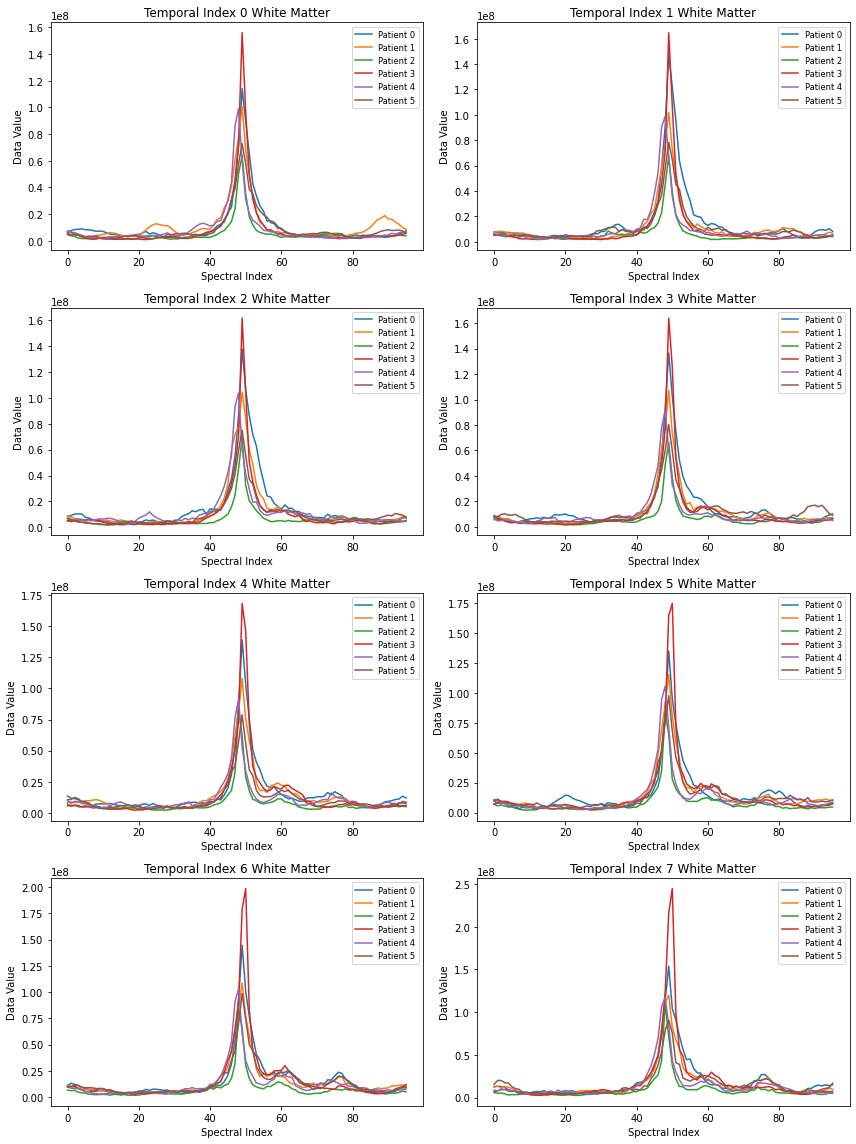

In [6]:
#### Load and apply white matter masks

mask_WM = np.load('../data/WM_masks.npy')
mask_WM_6D = mask_WM[:,:,:, np.newaxis, np.newaxis, :]


### Transform to spectral domain 
Ground_Truth_Spectral_L8_WM = np.fft.fftshift(np.fft.fft(Ground_Truth_L8, axis=-3),axes=-3)*mask_WM_6D
Undersampled_Data_Spectral_L8_WM = np.fft.fftshift(np.fft.fft(Undersampled_Data_L8, axis=-3),axes=-3)*mask_WM_6D

### Compute squared absolute difference wrt to ground truth
error = np.abs(Ground_Truth_Spectral_L8_WM - Undersampled_Data_Spectral_L8_WM)**2

### Average over spatial dimensions to get MSE for spatial dimenisons as a function 
mse_per_spatial_volume = np.mean(error, axis=(0, 1, 2))


# Create 8 subplots in a grid of 4 rows x 2 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Loop over each temporal index (0 to 7)
for temporal_idx in range(mse_per_spatial_volume.shape[1]):
    # Determine subplot indices for a 2-column layout
    row = temporal_idx // 2
    col = temporal_idx % 2
    ax = axs[row, col]
    
    # x-axis values: indices 0 to 95 (spectral indices)
    x = np.arange(mse_per_spatial_volume.shape[0])
    
    # Plot each patient's data for the current temporal index
    for patient_idx in range(mse_per_spatial_volume.shape[2]):
        ax.plot(x, mse_per_spatial_volume[:, temporal_idx, patient_idx],
                label=f'Patient {patient_idx}')
    
    ax.set_title(f"Temporal Index {temporal_idx}"+" White Matter")
    ax.set_xlabel("Spectral Index")
    ax.set_ylabel("Data Value")
    ax.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()


**Erros grey matter region**

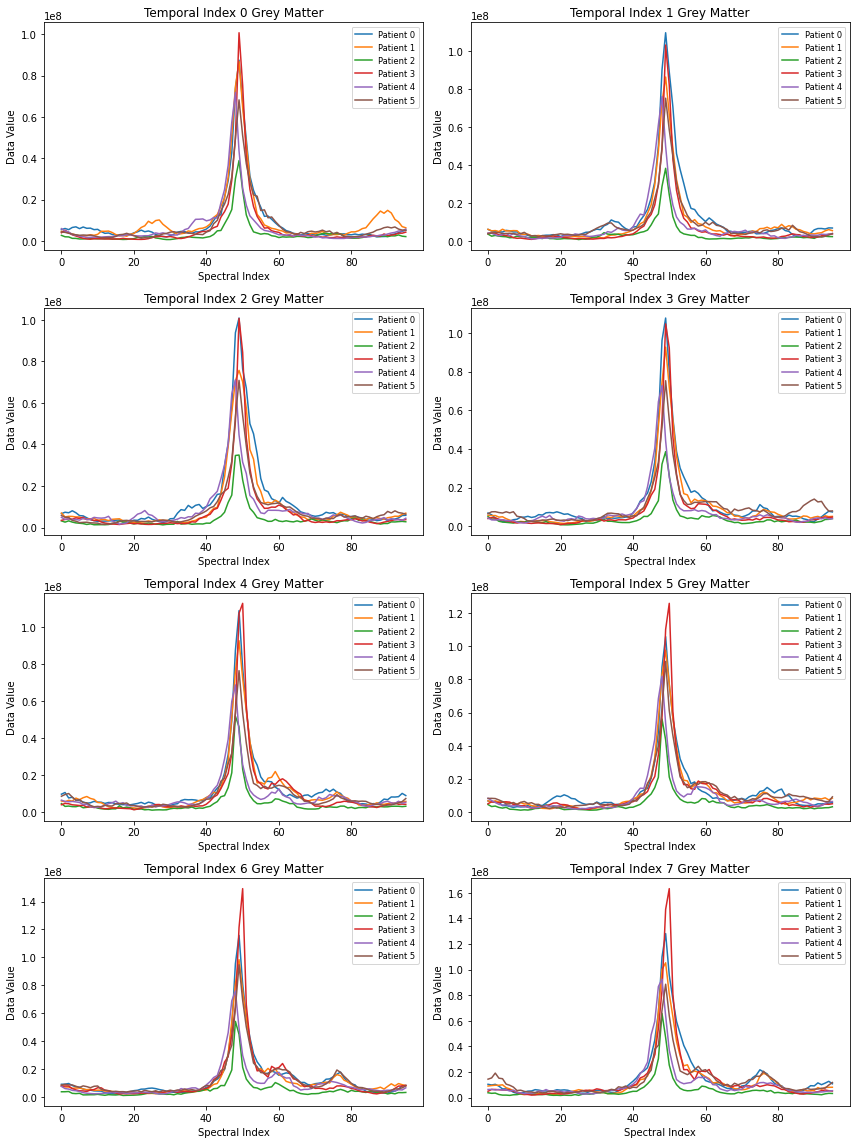

In [7]:
#### Load and apply white matter masks

mask_GM = np.load('../data/GM_masks.npy')
mask_GM_6D = mask_GM[:,:,:, np.newaxis, np.newaxis, :]


### Transform to spectral domain 
Ground_Truth_Spectral_L8_GM = np.fft.fftshift(np.fft.fft(Ground_Truth_L8, axis=-3),axes=-3)*mask_GM_6D
Undersampled_Data_Spectral_L8_GM = np.fft.fftshift(np.fft.fft(Undersampled_Data_L8, axis=-3),axes=-3)*mask_GM_6D

### Compute squared absolute difference wrt to ground truth
error = np.abs(Ground_Truth_Spectral_L8_GM - Undersampled_Data_Spectral_L8_GM)**2

### Average over spatial dimensions to get MSE for spatial dimenisons as a function 
mse_per_spatial_volume = np.mean(error, axis=(0, 1, 2))


# Create 8 subplots in a grid of 4 rows x 2 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Loop over each temporal index (0 to 7)
for temporal_idx in range(mse_per_spatial_volume.shape[1]):
    # Determine subplot indices for a 2-column layout
    row = temporal_idx // 2
    col = temporal_idx % 2
    ax = axs[row, col]
    
    # x-axis values: indices 0 to 95 (spectral indices)
    x = np.arange(mse_per_spatial_volume.shape[0])
    
    # Plot each patient's data for the current temporal index
    for patient_idx in range(mse_per_spatial_volume.shape[2]):
        ax.plot(x, mse_per_spatial_volume[:, temporal_idx, patient_idx],
                label=f'Patient {patient_idx}')
    
    ax.set_title(f"Temporal Index {temporal_idx}"+" Grey Matter")
    ax.set_xlabel("Spectral Index")
    ax.set_ylabel("Data Value")
    ax.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()

**Average peak hights**

Here I compute the average spectrum as a function of time first

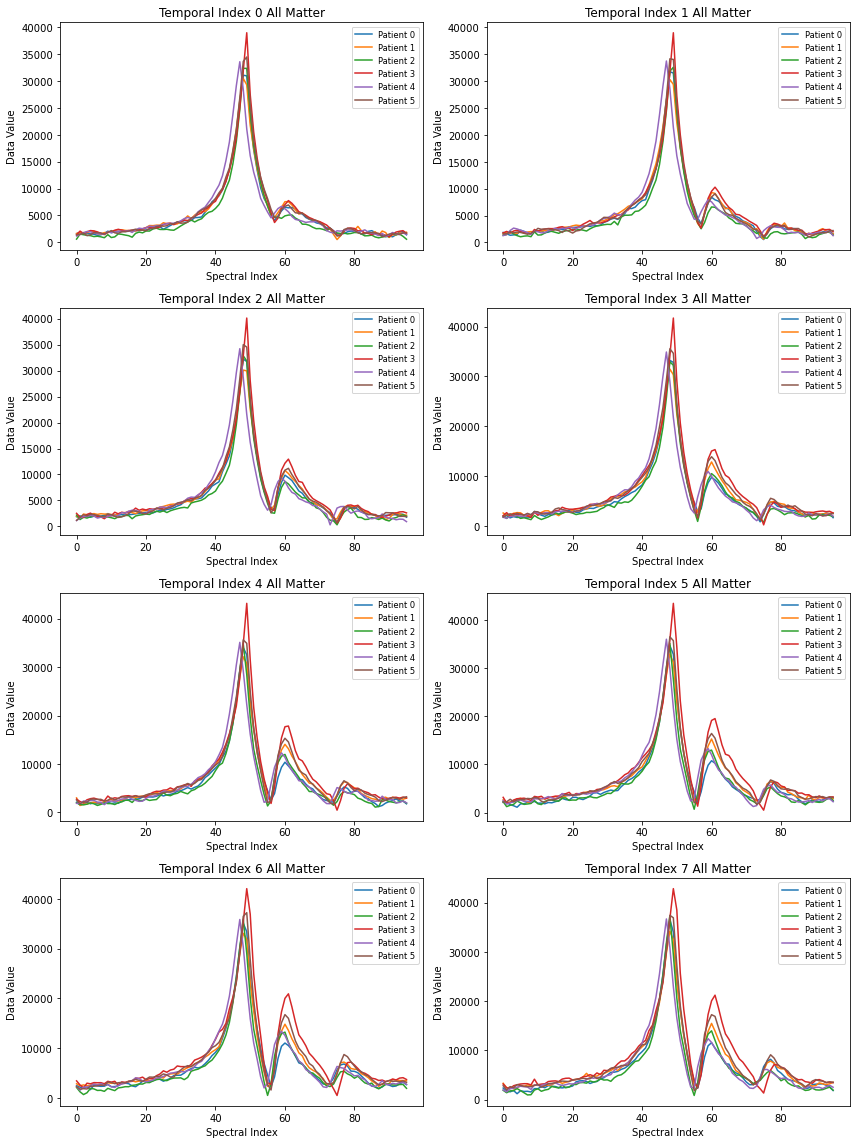

In [8]:
Ground_Truth_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_L8, axis=-3),axes=-3)
Undersampled_Data_Spectral_L8 = np.fft.fftshift(np.fft.fft(Undersampled_Data_L8, axis=-3),axes=-3)

Average_Spectrum_GT = np.abs(np.mean(Ground_Truth_Spectral_L8, axis=(0, 1, 2)))
#Average_Spectrum_US = np.mean(Undersampled_Data_Spectral_L8, axis=(0, 1, 2))

# Create 8 subplots in a grid of 4 rows x 2 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Loop over each temporal index (0 to 7)
for temporal_idx in range(Average_Spectrum_GT.shape[1]):
    # Determine subplot indices for a 2-column layout
    row = temporal_idx // 2
    col = temporal_idx % 2
    ax = axs[row, col]
    
    # x-axis values: indices 0 to 95 (spectral indices)
    x = np.arange(Average_Spectrum_GT.shape[0])
    
    # Plot each patient's data for the current temporal index
    for patient_idx in range(Average_Spectrum_GT.shape[2]):
        ax.plot(x, Average_Spectrum_GT[:, temporal_idx, patient_idx],
                label=f'Patient {patient_idx}')
    
    ax.set_title(f"Temporal Index {temporal_idx}"+" All Matter")
    ax.set_xlabel("Spectral Index")
    ax.set_ylabel("Data Value")
    ax.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()



Here the same for white matter

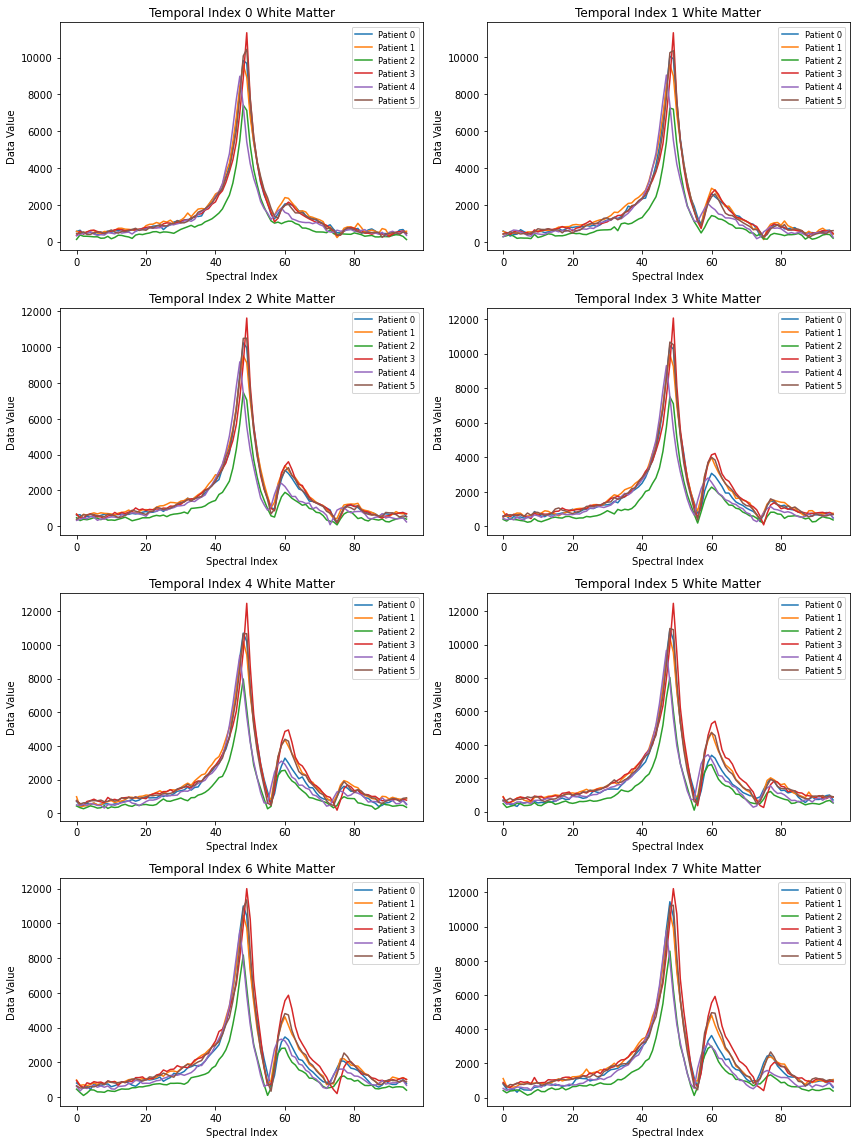

In [9]:
Average_Spectrum_GT = np.abs(np.mean(Ground_Truth_Spectral_L8_WM, axis=(0, 1, 2)))
#Average_Spectrum_US = np.mean(Undersampled_Data_Spectral_L8, axis=(0, 1, 2))

# Create 8 subplots in a grid of 4 rows x 2 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Loop over each temporal index (0 to 7)
for temporal_idx in range(Average_Spectrum_GT.shape[1]):
    # Determine subplot indices for a 2-column layout
    row = temporal_idx // 2
    col = temporal_idx % 2
    ax = axs[row, col]
    
    # x-axis values: indices 0 to 95 (spectral indices)
    x = np.arange(Average_Spectrum_GT.shape[0])
    
    # Plot each patient's data for the current temporal index
    for patient_idx in range(Average_Spectrum_GT.shape[2]):
        ax.plot(x, Average_Spectrum_GT[:, temporal_idx, patient_idx],
                label=f'Patient {patient_idx}')
    
    ax.set_title(f"Temporal Index {temporal_idx}"+" White Matter")
    ax.set_xlabel("Spectral Index")
    ax.set_ylabel("Data Value")
    ax.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()

And grey matter...

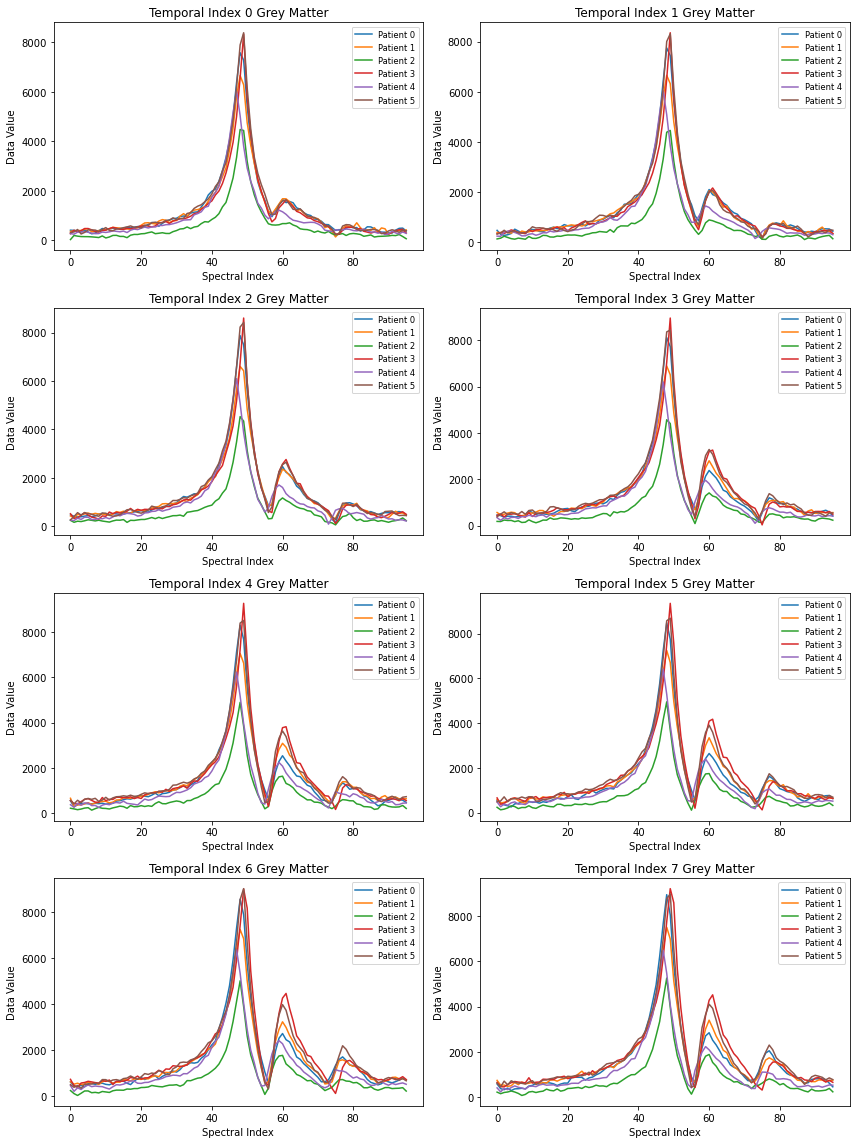

In [10]:
Average_Spectrum_GT = np.abs(np.mean(Ground_Truth_Spectral_L8_GM, axis=(0, 1, 2)))
#Average_Spectrum_US = np.mean(Undersampled_Data_Spectral_L8, axis=(0, 1, 2))

# Create 8 subplots in a grid of 4 rows x 2 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Loop over each temporal index (0 to 7)
for temporal_idx in range(Average_Spectrum_GT.shape[1]):
    # Determine subplot indices for a 2-column layout
    row = temporal_idx // 2
    col = temporal_idx % 2
    ax = axs[row, col]
    
    # x-axis values: indices 0 to 95 (spectral indices)
    x = np.arange(Average_Spectrum_GT.shape[0])
    
    # Plot each patient's data for the current temporal index
    for patient_idx in range(Average_Spectrum_GT.shape[2]):
        ax.plot(x, Average_Spectrum_GT[:, temporal_idx, patient_idx],
                label=f'Patient {patient_idx}')
    
    ax.set_title(f"Temporal Index {temporal_idx}"+" Grey Matter")
    ax.set_xlabel("Spectral Index")
    ax.set_ylabel("Data Value")
    ax.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()